## Sentiment Analysis using Amazon reveiws

in this notebook we will be doing some sentiment analysis using two different techniques:

1. Roberta Pretrained Model 
2. Huggingface pipeline
3. VADER (valence aware dictionary and sentiment reasonser) - bag of words approach

## 1- import nessecary libraries and read in data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.style.use('ggplot')

import nltk

# Download the Punkt tokenizer models
nltk.download('punkt')

# Download the averaged perceptron part-of-speech tagger
nltk.download('averaged_perceptron_tagger')
nltk.download('words')
nltk.download('maxent_ne_chunker')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/besherhasan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/besherhasan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/besherhasan/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/besherhasan/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!


True

In [2]:
df = pd.read_csv('Reviews.csv')

In [3]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
df.tail()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...
568453,568454,B001LR2CU2,A3LGQPJCZVL9UC,srfell17,0,0,5,1338422400,Great Honey,"I am very satisfied ,product is as advertised,..."


In [5]:
print(df.shape)

(568454, 10)


## Exploratory Data Analysis
note that the review is out of 5

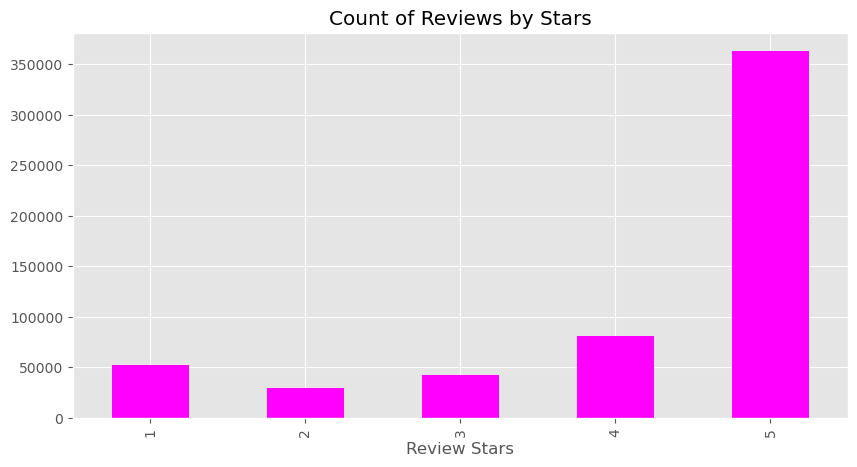

In [6]:
ax = df['Score'].value_counts().sort_index().plot(kind='bar', title='Count of Reviews by Stars', figsize=(10,5),color='magenta')

ax.set_xlabel('Review Stars')
plt.show()

## Now we will explore basic NLTK

In [7]:
example = df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [8]:
tokens = nltk.word_tokenize(example)
# tokenize mean that it splits each word so it will help the computer to understand that
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [9]:
tagged = nltk.pos_tag(tokens)
tagged[:10]
# these tags beside the text are codes for part of speach we can search for them in google

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [10]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


## Next step is use VADER Seniment Scoring

we will use NLTKs SentimentIntensityAnalyzer to get the negative/neutral/positive scores of the text

* this uses a "bag of words" approach:

1. Stop words are removed like {and, or ... etc because they dont have effect positive / negative}
2. each word is scored and combined to a total score

In [11]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

# Download the VADER lexicon
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/besherhasan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [12]:
sia.polarity_scores('I am so excited and happy to see you!')
# the score will be from 0 to 1

{'neg': 0.0, 'neu': 0.463, 'pos': 0.537, 'compound': 0.7875}

In [13]:
sia.polarity_scores("this is the worst day ever")

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [14]:
# now we will try it on our example review
sia.polarity_scores(example)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [17]:
# Run the polarity score on the entire dataset 
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row["Text"]
    myid = row["Id"]
    res[myid] = sia.polarity_scores(text)


  0%|          | 0/568454 [00:00<?, ?it/s]

In [18]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index':'Id'})
vaders = vaders.merge(df, how='left')

In [19]:
# Now we have sentiment score and metadata

vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## plot VADER reesult

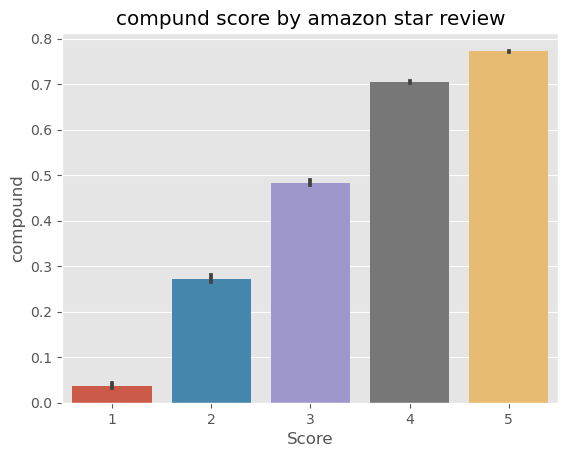

In [20]:

import warnings


# Filter out the specific FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)

ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('compund score by amazon star review')
plt.show()
# Filter out the FutureWarning


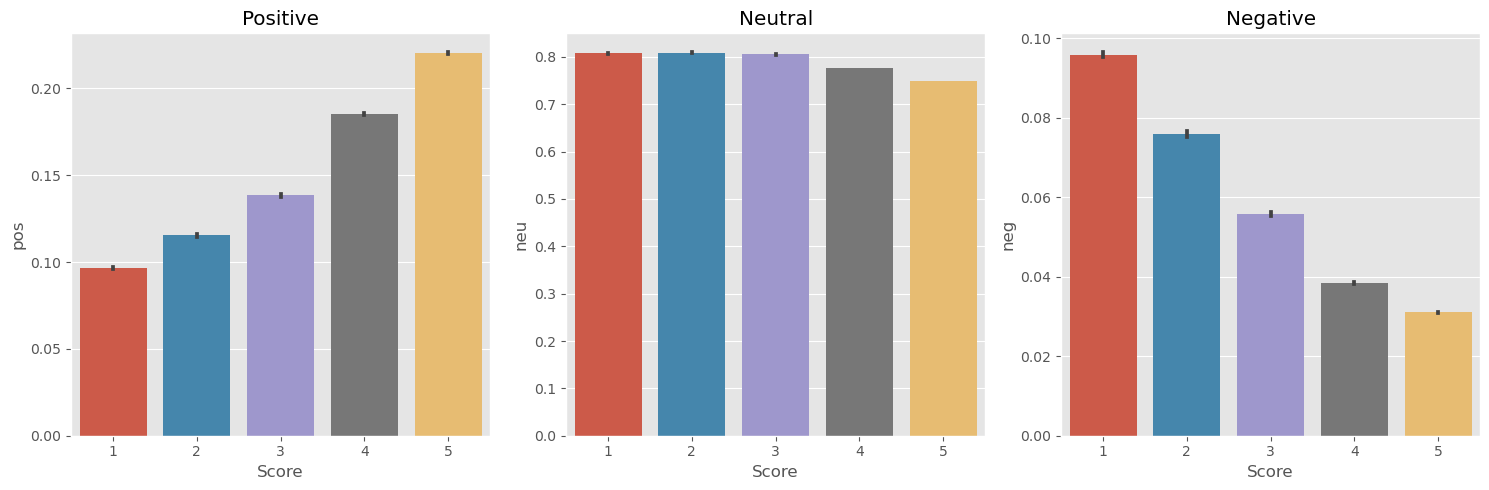

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))

sns.barplot(data=vaders, x="Score",y='pos',ax= axs[0])
sns.barplot(data=vaders, x='Score',y='neu', ax= axs[1])
sns.barplot(data=vaders, x='Score',y='neg', ax= axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

## step3. Roberta Pretrained Model

* Use a model trained of a large corpus of data.
* Transformer model accounts for the words but also the context related to other words.

In [23]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification

from scipy.special import softmax

In [24]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [25]:
# VADER results on example
print(example)
sia.polarity_scores(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [26]:
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
    
}
print(scores_dict)


{'roberta_neg': 0.97635514, 'roberta_neu': 0.020687481, 'roberta_pos': 0.002957372}


In [29]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    
    }
    return scores_dict


In [37]:
res = {}
for i, row in tqdm(df.head(500).iterrows(), total=500):
    try:
        text = row["Text"]
        myid = row["Id"]
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
    
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/500 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187


In [34]:
both

{'vader_neg': 0.0,
 'vader_neu': 0.695,
 'vader_pos': 0.305,
 'vader_compound': 0.9441,
 'roberta_neg': 0.009624235,
 'roberta_neu': 0.0499804,
 'roberta_pos': 0.94039536}

In [41]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index':'Id'})
results_df = results_df.merge(df, how='left')

In [42]:
results_df.head()

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940395,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,0.508986,0.452414,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,0.003229,0.098067,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## compare scores between models

In [43]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

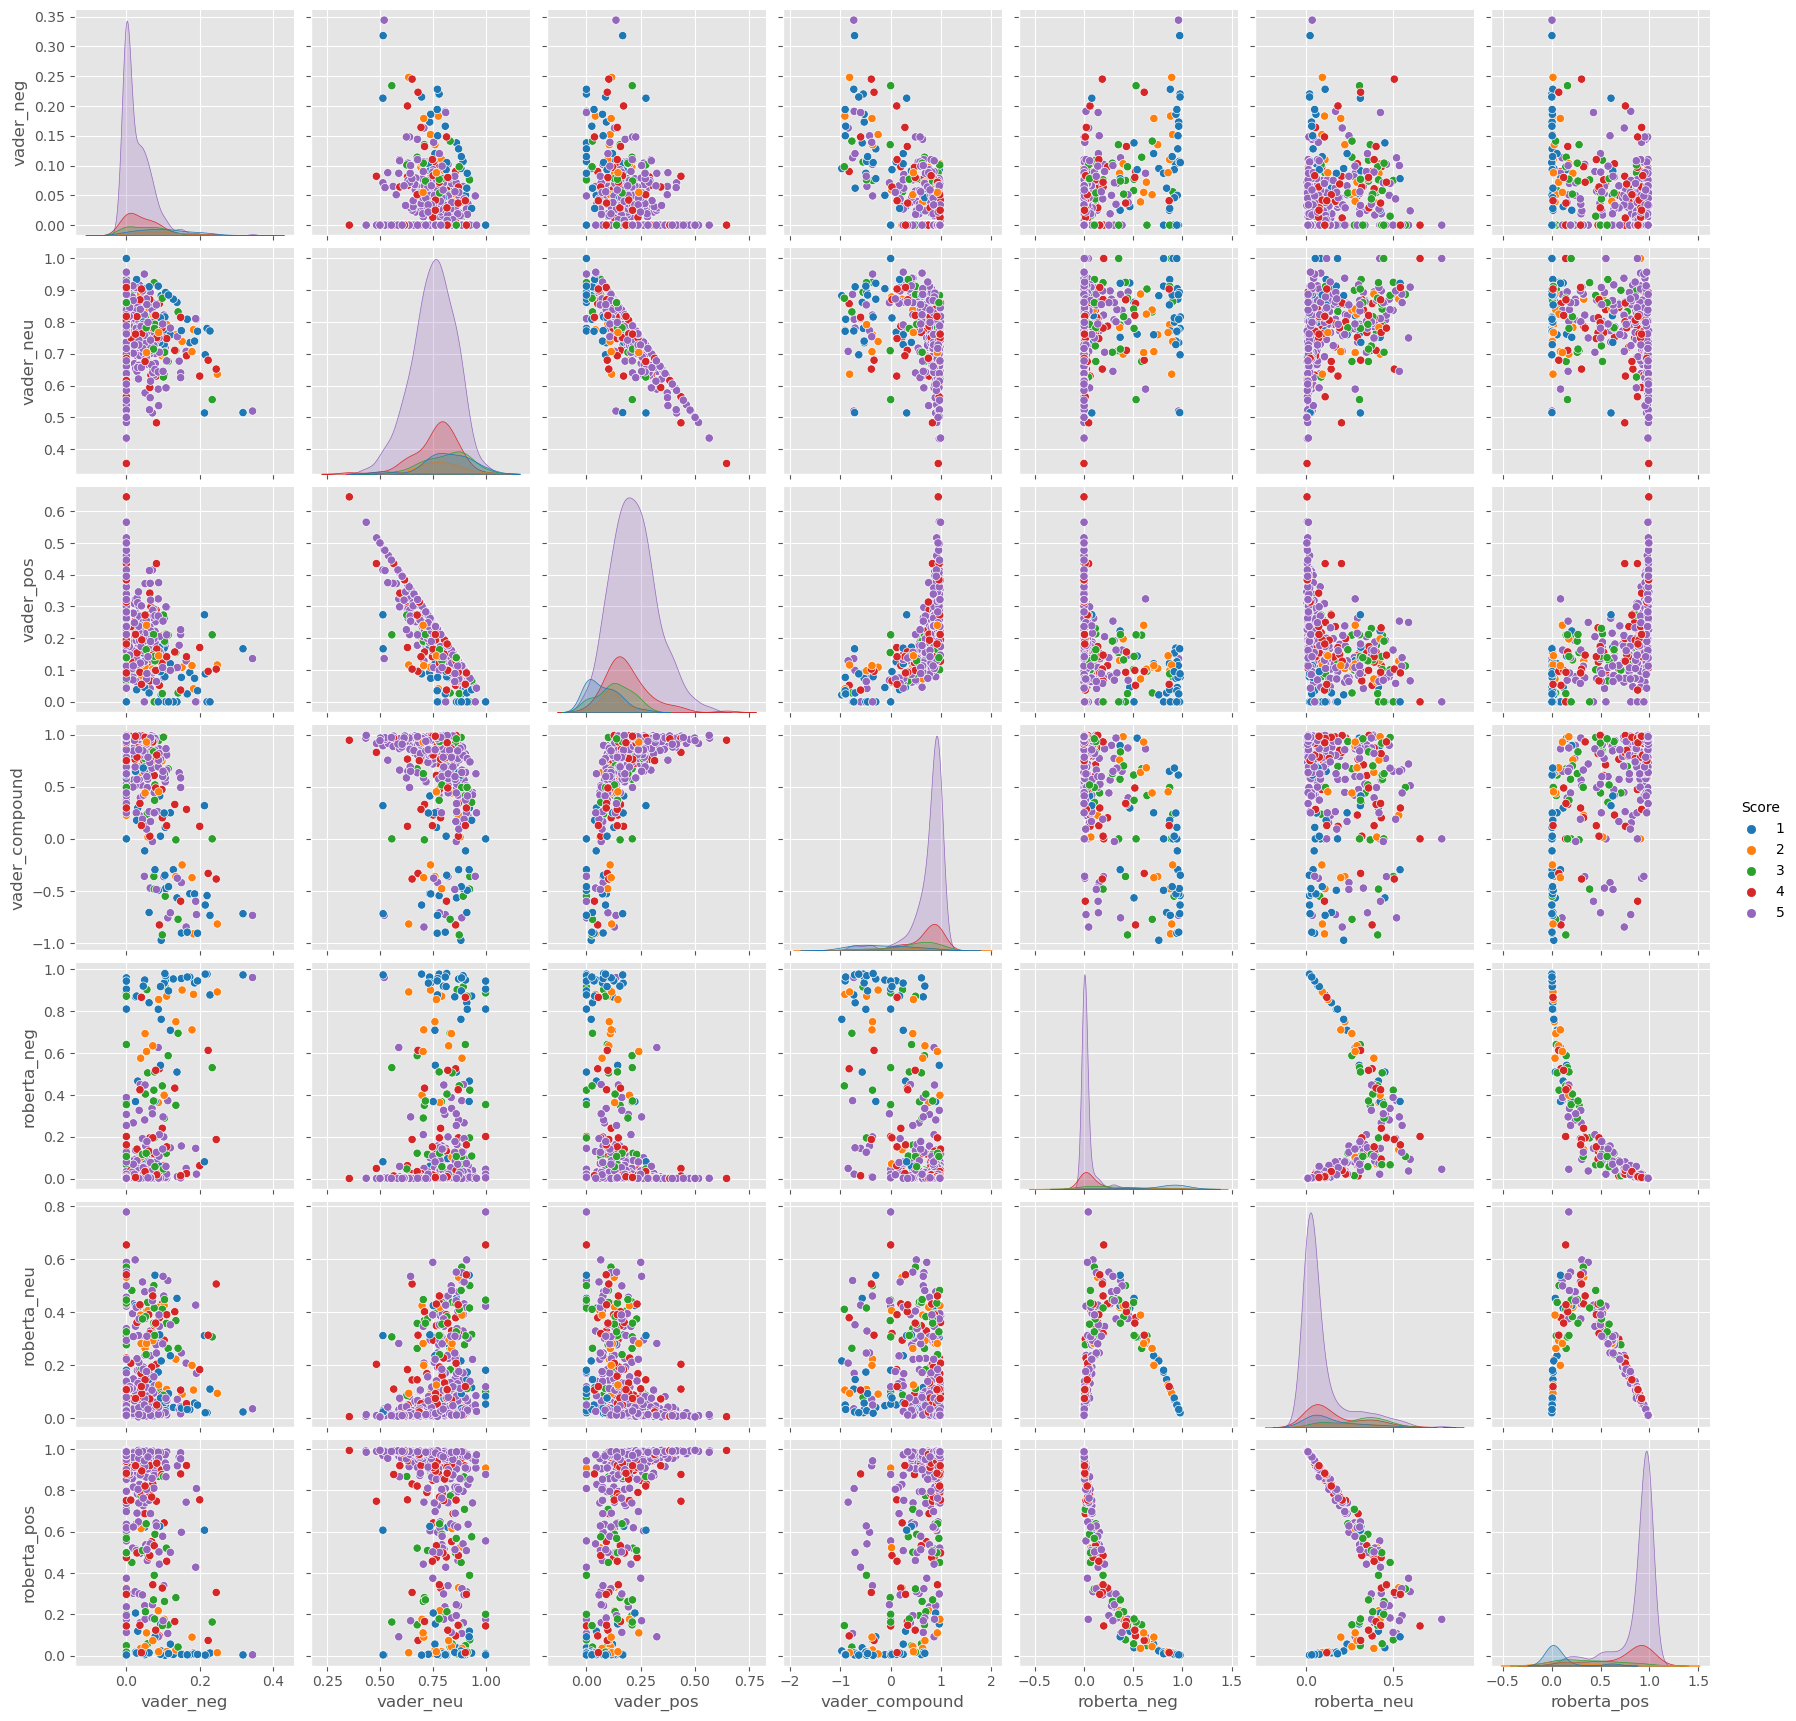

In [45]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

sns.pairplot(data=results_df, vars=['vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos'],
             hue='Score',
             palette='tab10'
            
            
            )
plt.show()

## Step 4 : Review Examples:

* Positive 1-Star and Negative 5-start Reviews

Lets look at some examples where the model scoring and review score differe the most.

In [47]:
results_df.query('Score == 1') \
    .sort_values('roberta_pos', ascending=False)['Text'].values[0]

'I felt energized within five minutes, but it lasted for about 45 minutes. I paid $3.99 for this drink. I could have just drunk a cup of coffee and saved my money.'

In [49]:
results_df.query('Score == 1') \
.sort_values('vader_pos', ascending=False)['Text'].values[0]

'So we cancelled the order.  It was cancelled without any problem.  That is a positive note...'

In [50]:
# Negative sentiment 5-star review

In [51]:
results_df.query('Score == 5') \
    .sort_values('roberta_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

In [52]:
results_df.query('Score == 5') \
    .sort_values('vader_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

 ## the transformers pipeline
 
 * its a quick and easy way to run sentiment prediction

In [53]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [54]:
# now its installed we can directly try without setup 


In [56]:
sent_pipeline('i fell it boring movie')

[{'label': 'NEGATIVE', 'score': 0.9998001456260681}]

In [57]:
sent_pipeline('i went to mall but the mall was crowded')

[{'label': 'NEGATIVE', 'score': 0.9956871867179871}]

In [58]:
sent_pipeline('i prefer pizza from another resturant than this')

[{'label': 'NEGATIVE', 'score': 0.8959030508995056}]

In [59]:
sent_pipeline('i love shawerma')

[{'label': 'POSITIVE', 'score': 0.9997153878211975}]